# Prepare environment

In [11]:
import torch
from matplotlib import pyplot as plt


from torch.utils.data import DataLoader
from dataset.STARCOP_dataset import STARCOPDataset
from dataset.dataset_info import ClassifierDatasetInfo
from dataset.dataset_type import DatasetType
from models.Tools.FilesHandler.model_files_handler import ModelFilesHandler
from models.Convolutional.MethaNet.model import MethaNetClassifier

import  os
os.chdir(r"D:\Projects\studia\polsl_ssi_1\MethaneDetection\Thesis")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load sample images

In [12]:
dataset = STARCOPDataset(
    data_path=r"data",
    data_type=DatasetType.TEST,
    image_info_class=ClassifierDatasetInfo,
    normalization=False
)

dataloader = DataLoader(dataset, batch_size=6, shuffle=True)

# Visualize inputs

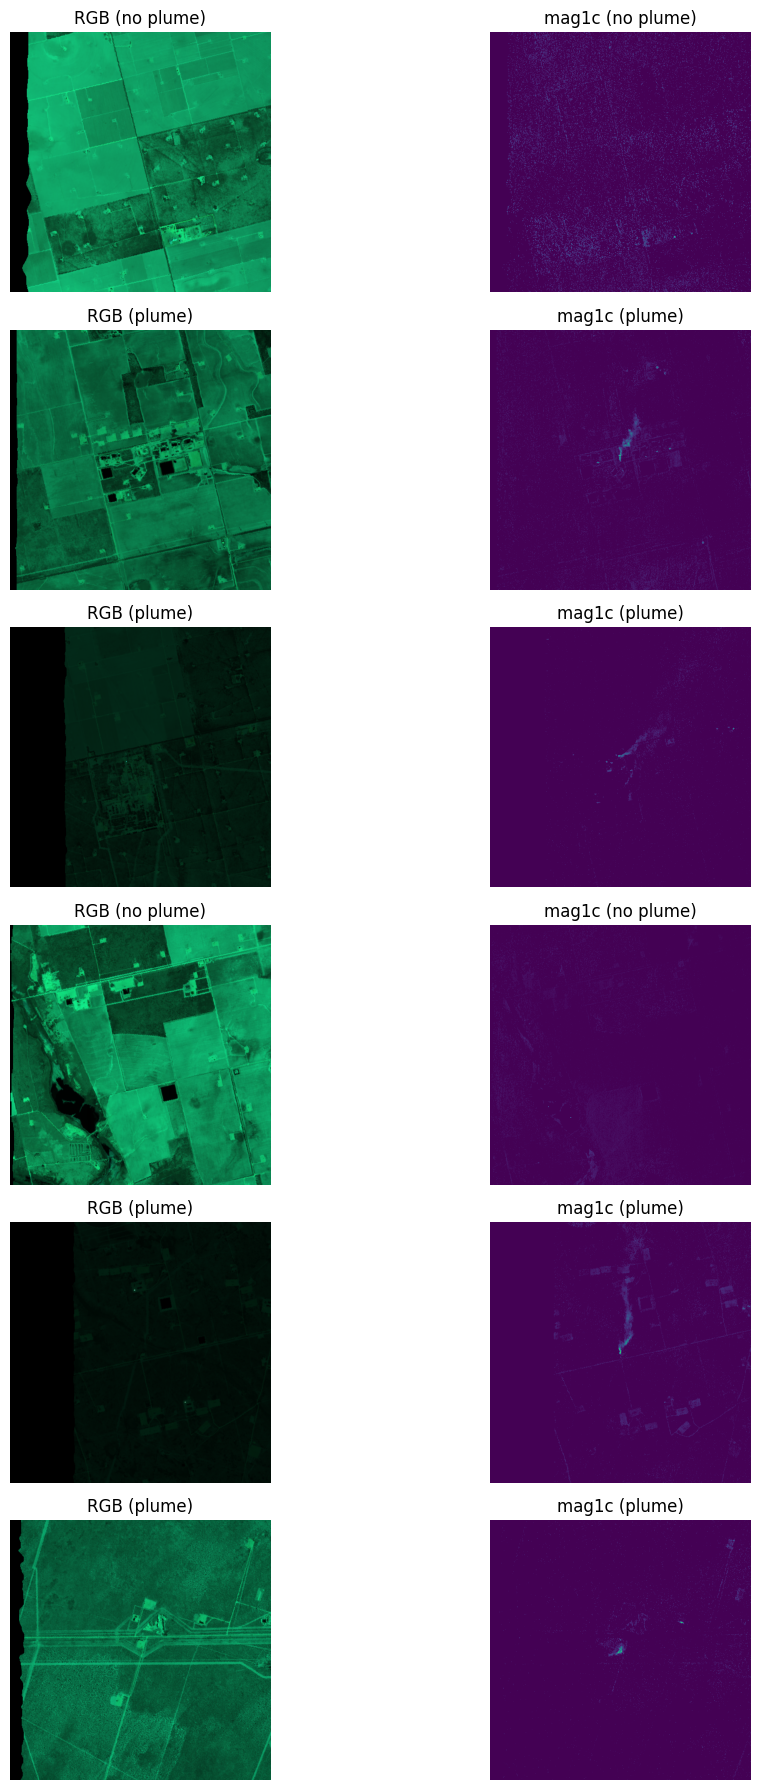

In [13]:
images = next(iter(dataloader))

# Create a figure with subplots
fig, ax = plt.subplots(6, 2, figsize=(12, 18))  # 6 row, 3 columns

# Display the first image
for i in range(images[0].shape[0]):
    image_rgb = images[0][i, :3, :, :].permute(1, 2, 0).numpy()
    image_mag1c = images[1][i].squeeze(0).numpy()

    image_rgb = image_rgb - image_rgb.min()  # Shift minimum to 0
    image_rgb = image_rgb / image_rgb.max()  # Scale maximum to 1

    plume = images[2][i].item()
    ax[i, 0].imshow(image_rgb)
    ax[i, 0].set_title(f"RGB ({"plume" if plume == True else "no plume"})")
    ax[i, 0].axis('off')

    # Display the second image
    ax[i, 1].imshow(image_mag1c)  # Automatically handles RGB
    ax[i, 1].set_title(f"mag1c ({"plume" if plume == True else "no plume"})")
    ax[i, 1].axis('off')  # Turn off axis

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.tight_layout()
plt.show()

# Prepare input for model

In [14]:
input_image = torch.cat((images[0], images[1]), dim=1)
input_image = input_image.to(device)

# Prepare model

In [15]:
file_name = r"trained_models\model_cnn_2024_12_12_13_47_08.pickle"

model_handler = ModelFilesHandler()
model, model_type, metrics, epoch = model_handler.load_model(file_name=file_name)

model.eval()
model.to(device)

MethaNetClassifier(
  (pre_conv): Sequential(
    (0): Conv2d(9, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(4, 2, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(2, 1, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(12, 16, kernel_size=(4, 4), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.2, inplace=False)
    (9): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=59536, out_features=64, bias=True)
    (2): ReLU()
    (3):

# Show performance

In [16]:
outputs = model(input_image.to(device))
print(f"Labels:  {images[2].numpy()}")
print(f"Outputs: {torch.argmax(outputs, dim=1).bool().to("cpu").numpy()}")

Labels:  [False  True  True False  True  True]
Outputs: [False  True  True False  True  True]


In [17]:
metrics

,TP,FP,FN,TN,Precision,Sensitivity,Specificity,NPV,FPR,Accuracy,F-Score,IoU,MCC,AUC,CI
0,0.263158,0.002924,0.225146,0.508772,0.989011,0.538922,0.994286,0.693227,0.005714,tensor(0.7719),0.697674,tensor(0.5357),0.603137,0.766604,"(1.0, 1.0)"
